<a href="https://colab.research.google.com/github/lwx-3000/Deep_Neuron_Network/blob/main/D2L_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

In [ ]:
x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

In [ ]:
# Can also create x = torch.arange(4.0, requires_grad=True)
x.requires_grad_(True)
x.grad  # The gradient is None by default

In [ ]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

We can now take the gradient of y with respect to x by calling its backward method

In [ ]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

In [ ]:
x.grad == 4*x

tensor([True, True, True, True])

We already know that the gradient of the function
 with respect to y = 2x^x
 should be 4x
. We can now verify that the automatic gradient computation and the expected result are identical.

In [ ]:
x.grad.zero_()  # Reset the gradient
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

In [ ]:
x.grad.zero_()
y = x * x
y.backward(gradient=torch.ones(len(y)))  # Faster: y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

In [ ]:
net = nn.Sequential(nn.LazyLinear(256),nn.ReLU(),nn.LazyLinear(10))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
X = torch.randn(2,20)
X

tensor([[ 0.9350, -2.0579,  0.4345,  1.2436,  1.1165, -1.8421,  2.0251,  1.5906,
         -0.2357,  1.2980, -1.3999, -0.5087, -0.0482,  0.5435, -0.9062, -0.5223,
          0.0985,  0.1847,  0.0515,  0.0072],
        [ 0.0229, -1.1472,  0.4754,  0.5048,  0.3474, -0.2435, -1.7911,  0.3995,
          0.0367,  0.0201,  0.1241, -0.5395,  0.6898,  1.8902,  1.2307,  0.2173,
         -0.8812, -0.8769,  1.2925, -1.6265]])

In [ ]:
X.shape

torch.Size([2, 20])

In [ ]:
net(X)

tensor([[-0.4512,  0.0970, -0.1323,  0.0497, -0.0230,  0.2717, -0.1658, -0.1481,
          0.0221,  0.2958],
        [ 0.0124, -0.2142, -0.0150, -0.2482,  0.2759,  0.2827, -0.0579,  0.1959,
          0.0052,  0.2479]], grad_fn=<AddmmBackward0>)

In [ ]:
net.__call__(X)

tensor([[-0.4512,  0.0970, -0.1323,  0.0497, -0.0230,  0.2717, -0.1658, -0.1481,
          0.0221,  0.2958],
        [ 0.0124, -0.2142, -0.0150, -0.2482,  0.2759,  0.2827, -0.0579,  0.1959,
          0.0052,  0.2479]], grad_fn=<AddmmBackward0>)

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    # Call the constructor of the parent class nn.Module to perform
    # the necessary initialization
    super().__init__()
    self.hidden = nn.LazyLinear(257)
    self.out = nn.LazyLinear(10)

  def forward(self, X):
    return self.out(F.relu(self.hidden(X)))


In [ ]:
net = MLP()
net(X).shape

torch.Size([2, 10])

### My-Sequential Model

In [ ]:
class MySequential(nn.Module):
  def __init__(self,*args):
    super().__init__()
    for idx, module in enumerate(args):
      self.add_module(str(idx),module)

  def forward(self,X):
    for module in self.children():
      X = module(X)
    return X

In [ ]:
net = MySequential(nn.LazyLinear(256),nn.ReLU(),nn.LazyLinear(10))
net(X).shape

torch.Size([2, 10])

It is the same as of using nn.Sequential()

In [ ]:
class FixedHiddenMLP(nn.Module):
  def __init__(self):
    super().__init__()
    # Random weight parameters that will not compute gradients and
    # therefore keep constant during training
    self.rand_weight = torch.randn(20,20)
    self.linear = nn.LazyLinear(20)
  def forward(self,X):
    X = self.linear(X)
    X = F.relu(X @ self.rand_weight + 1)
    # Reuse the fully connected layer. This is equivalent to sharing
    # parameters with two fully connected layers
    X = self.linear(X)
    while X.abs().sum() > 1:
      X /= 2
    return X.sum()

In [ ]:
net = FixedHiddenMLP()
net(X)

tensor(0.2951, grad_fn=<SumBackward0>)

Note that "module re-use" of the self.linear() layer. First time X pass throught self.linear() layer and been transformed by it, then X pass through self.linear the second time, transformed by the same weights on this layer.  

mix and match various ways of assembling modules together(Net and layer)

In [ ]:
class NestMLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(nn.LazyLinear(64),nn.ReLU(),
                             nn.LazyLinear(32),nn.ReLU())
    self.linear = nn.LazyLinear(16)

  def forward(self,X):
    return self.linear(self.net(X))

chimera =  nn.Sequential(NestMLP(),nn.LazyLinear(20),FixedHiddenMLP())
chimera(X)

tensor(0.1811, grad_fn=<SumBackward0>)

Conclusion:


*   Every individual layer can be a module, a group of layers can also be a module.
* A modlue is represented by a class. Every subclass of it must contains

1.   a forward propergation (transform input into output)

2.   must store any
necessary parameters.
3. a module must possess a backpropergation method (for gradient calculation)

*   A module can contain code, module can take care of housekeeping, including parameter initialization and backpropergation. Sequential module handles seuqential concatenation of layers and modules.




####6.2 Parameter Management

In [ ]:
import torch
from torch import nn

In [ ]:
net = nn.Sequential(nn.LazyLinear(6),nn.ReLU(),nn.LazyLinear(4),nn.ReLU(),nn.LazyLinear(2))
X = torch.randn(size=(2,3))
net(X).shape

torch.Size([2, 2])

In [ ]:
net[0].state_dict()

OrderedDict([('weight',
              tensor([[ 0.2266,  0.1845,  0.3314],
                      [-0.0744,  0.0695, -0.0480],
                      [-0.4897, -0.3322,  0.0885],
                      [ 0.0252,  0.3941,  0.2883],
                      [-0.1178,  0.5056, -0.3219],
                      [ 0.1745, -0.4859, -0.5362]])),
             ('bias',
              tensor([-0.3233, -0.2404,  0.5011, -0.5556,  0.4311, -0.4701]))])

In [ ]:
net[2].state_dict()

OrderedDict([('weight',
              tensor([[-0.1588, -0.3976,  0.1305, -0.2323,  0.1231, -0.1619],
                      [-0.1375, -0.3609, -0.3186, -0.3507,  0.0884,  0.3285],
                      [ 0.3923, -0.2840,  0.0198,  0.3775, -0.2475, -0.3222],
                      [ 0.3025, -0.1752, -0.1813, -0.1560,  0.3943, -0.2000]])),
             ('bias', tensor([-0.3351, -0.1726,  0.1295, -0.3815]))])

In [ ]:
net[4].state_dict()

OrderedDict([('weight',
              tensor([[-0.2778, -0.2521, -0.1469,  0.1210],
                      [ 0.3330,  0.1358, -0.4023,  0.4267]])),
             ('bias', tensor([ 0.0163, -0.0188]))])

Looks like: net[0] , net[1] are the first layer parameters and ReLU object, since input is flatten into 1 dimension.

And net[2] , net[3] are the second layer P and ReLU. Parameter layers has the width of previous layers(=6) and layer number of current layer(=4), so it is 4x6.  Bias remains to be 1x4.

So do net[4] , net[5] they are the P(2x4) and B(1x2), ReLU object of layer 3 (output layer).


In [ ]:
type(net[0].bias), net[0].bias.data, net[0].weight.data

(torch.nn.parameter.Parameter,
 tensor([-0.3233, -0.2404,  0.5011, -0.5556,  0.4311, -0.4701]),
 tensor([[ 0.2266,  0.1845,  0.3314],
         [-0.0744,  0.0695, -0.0480],
         [-0.4897, -0.3322,  0.0885],
         [ 0.0252,  0.3941,  0.2883],
         [-0.1178,  0.5056, -0.3219],
         [ 0.1745, -0.4859, -0.5362]]))

In [ ]:
# In addition to the value,
# each parameter also allows us to access the gradient.
# Because we have not invoked backpropagation for this network yet,
# it is in its initial state.
net[0].weight.grad == None

True

All Parameters at Once

In [ ]:
[(name,param) for name, param in net.named_parameters()]

[('0.weight',
  Parameter containing:
  tensor([[-0.3711,  0.2248,  0.1502],
          [-0.1330, -0.3535,  0.1657],
          [ 0.2067,  0.4931, -0.5007],
          [-0.5081,  0.0558,  0.2863],
          [-0.0808,  0.0957,  0.1473],
          [-0.0140,  0.0881, -0.1280],
          [ 0.0515, -0.5077,  0.3828],
          [-0.5431,  0.3533,  0.0402]], requires_grad=True)),
 ('0.bias',
  Parameter containing:
  tensor([-0.3401, -0.2928, -0.4185, -0.1395, -0.0291, -0.2578,  0.5385, -0.2797],
         requires_grad=True)),
 ('2.weight',
  Parameter containing:
  tensor([[ 1.0000e+02,  1.1377e-01,  1.9768e-01, -2.4250e-01,  2.2349e-01,
            3.4374e-01,  1.2180e-01, -1.0737e-02],
          [ 1.3921e-01,  2.9514e-01, -2.5366e-03, -1.4292e-01,  3.0224e-01,
           -1.3272e-01,  6.3063e-03,  7.7187e-02],
          [ 7.3096e-02, -3.0710e-01, -2.6736e-01, -3.0408e-01,  2.3661e-01,
            2.9456e-01,  2.3402e-01,  6.9717e-02],
          [-1.4744e-01, -2.4281e-01,  1.7768e-01,  5.7606e

net.named_parameters() contains name, and parameters. And parameters contains weight, bias, gradients.

#### Tied Parameters

In [ ]:
# We need to give the shared layer a name so that we can refer to its
# parameters

shared = nn.LazyLinear(8)
net = nn.Sequential(nn.LazyLinear(8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.LazyLinear(1))

net(X)
# Check whether the parameters are the same
print(net[2].weight.data[0] == net[4].weight.data[0])

# What if we change the value of a spcific parameter
net[2].weight.data[0, 0] = 100
# Make sure that they are actually the same object rather than just having the
# same value
print(net[2].weight.data[0] == net[4].weight.data[0])


tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


This example shows that how to tie the 2nd and 3rd layer of parameter. The 2nd and 3rd are not only have the same value. **They are the same tensor**. Thus we change one of the parameter, the other one changes too.

---

You might wonder, when parameters are tied what happens to the gradients? Since the model parameters contain gradients, the gradients of the second hidden layer and the third hidden layer are added together during backpropagation.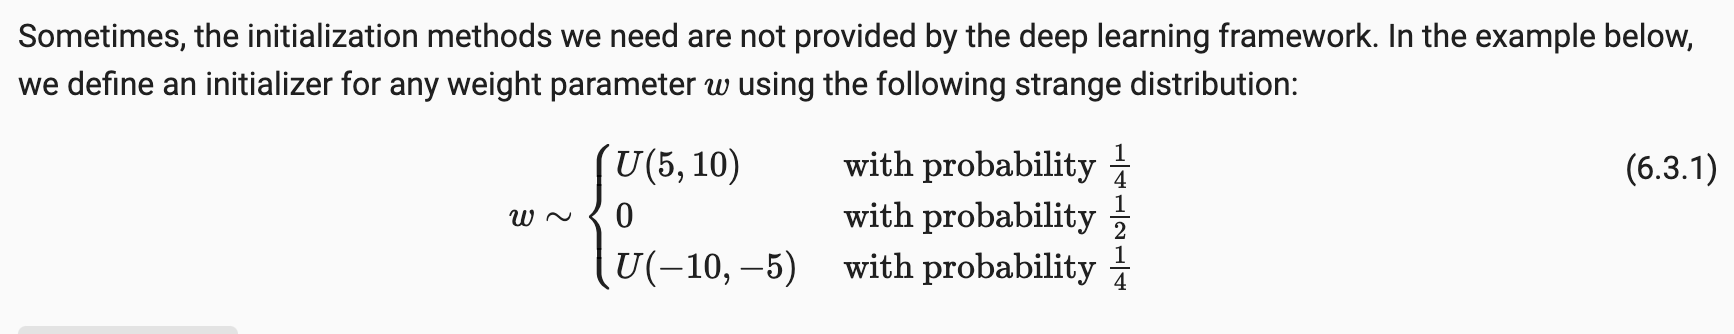



In [ ]:
print(net.state_dict())

OrderedDict([('0.weight', tensor([[-0.3711,  0.2248,  0.1502],
        [-0.1330, -0.3535,  0.1657],
        [ 0.2067,  0.4931, -0.5007],
        [-0.5081,  0.0558,  0.2863],
        [-0.0808,  0.0957,  0.1473],
        [-0.0140,  0.0881, -0.1280],
        [ 0.0515, -0.5077,  0.3828],
        [-0.5431,  0.3533,  0.0402]])), ('0.bias', tensor([-0.3401, -0.2928, -0.4185, -0.1395, -0.0291, -0.2578,  0.5385, -0.2797])), ('2.weight', tensor([[ 1.0000e+02,  1.1377e-01,  1.9768e-01, -2.4250e-01,  2.2349e-01,
          3.4374e-01,  1.2180e-01, -1.0737e-02],
        [ 1.3921e-01,  2.9514e-01, -2.5366e-03, -1.4292e-01,  3.0224e-01,
         -1.3272e-01,  6.3063e-03,  7.7187e-02],
        [ 7.3096e-02, -3.0710e-01, -2.6736e-01, -3.0408e-01,  2.3661e-01,
          2.9456e-01,  2.3402e-01,  6.9717e-02],
        [-1.4744e-01, -2.4281e-01,  1.7768e-01,  5.7606e-02, -6.3090e-02,
         -6.8345e-02,  3.0552e-01, -3.2464e-01],
        [-1.0759e-02,  1.3336e-01,  1.6595e-01, -3.3030e-01,  1.4434e-01,
  

In [ ]:
print(net)

Sequential(
  (0): Linear(in_features=3, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=8, bias=True)
  (5): ReLU()
  (6): Linear(in_features=8, out_features=1, bias=True)
)


In [ ]:
def block1():
  return nn.Sequential(nn.LazyLinear(8),nn.ReLU(),
                       nn.LazyLinear(4),nn.ReLU())

def block2():
  net = nn.Sequential()
  for i in range(4):
    net.add_module(f'block {i}', block1()) # string literals f '{i}' for parameter i
  return net

rgnet = nn.Sequential(block2(), nn.LazyLinear(2))
print(rgnet(X))

tensor([[0.1251, 0.2327],
        [0.1251, 0.2327]], grad_fn=<AddmmBackward0>)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
print(rgnet)

Sequential(
  (0): Sequential(
    (block 0): Sequential(
      (0): Linear(in_features=3, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=2, bias=True)
)


In [ ]:
X.shape

torch.Size([2, 3])

In [ ]:
rgnet[0][0][2].bias.data #first block, first sub_block, second layer

tensor([-0.2685, -0.0414,  0.1326, -0.2902])

###6.3 Parameter Initialization

In [ ]:
import torch
from torch import nn

In [ ]:
net = nn.Sequential(nn.LazyLinear(8), nn.ReLU(), nn.LazyLinear(1))
X = torch.rand(size=(2, 4))
net(X).shape

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([2, 1])

####6.3.1. Built-in Initialization

In [ ]:
def init_normal(module):
  if type(module) == nn.Linear:
    nn.init.normal_(module.weight, mean=0, std=0.1) # bot normal_ and zeros_ with under score "_" means:
    nn.init.zeros_(module.bias)                     # instead of return a new tensor, it will MODIFY the original tensor inplace.
net.apply(init_normal) # apply function apply function "init_normal" to all modules (and its sub_modules) iteratively.
net[0].weight.data[0], net[0].bias.data[0]

(tensor([ 0.0673,  0.0651, -0.0119, -0.1592]), tensor(0.))

In [ ]:
def init_constant(module):
  if type(module) == nn.Linear:
    nn.init.constant_(module.weight, 1)
    nn.init.zeros_(module.bias)
net.apply(init_constant)

net[0].weight.data[0], net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

In [ ]:
def init_xavier(module):
  if type(module) == nn.Linear:
    nn.init.xavier_uniform(module.weight)

def init_42(module):
  if type(module) == nn.Linear:
    nn.init.constant_(module.weight, 42)

net[0].apply(init_xavier)
net[2].apply(init_42)
print(net[0].weight.data[0])
print(net[2].weight.data)

tensor([0.0643, 0.2517, 0.0937, 0.5475])
tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])


<ipython-input-77-af56dd069071>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(module.weight)


####6.3.1.1. Custom Initialization

ω =
1. 𝗨 (5,10) with P = 1/4
2. 0 with P = 1/2
3. 𝗨 (-10,5) with P = 1/4

In [ ]:
def my_init(module):
  if type(module) == nn.Linear:
    print("Init" , *[(name, param.shape) for name,
                     param in module.named_parameters()][0]) # * inside print is for unpacking iterabale element, like iterater. ** for dictionary unpack
    nn.init.uniform_(module.weight, -10, 10)
    module.weight.data *= module.weight.data.abs() >= 5

net.apply(my_init)
net[0].weight[:2]


Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


tensor([[-8.7334, -0.0000,  0.0000,  6.3641],
        [-9.6881,  8.5172, -5.7856, -9.4963]], grad_fn=<SliceBackward0>)

In [ ]:
#Note that we always have the option of setting parameters directly.

net[0].weight.data[:] += 1
net[0].weight.data[0,0] = 42
net[0].weight.data[0]

tensor([42.0000,  1.0000,  1.0000,  7.3641])

Summary: We can initialize weight using built-in and custom initializers.

###Lazy Initialization


In [ ]:
import torch
from torch import nn

In [ ]:
net = nn.Sequential(nn.LazyLinear(256),nn.ReLU(),nn.LazyLinear(10))
net[0].weight

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<UninitializedParameter>

In [ ]:
X = torch.rand(2,20)
net(X)

net[0].weight.shape

torch.Size([256, 20])

In [ ]:
def apply_init(self, inputs, init=None):
    self.forward(*inputs)
    if init is not None:
        self.net.apply(init)

### Custom Layers

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F


#### 6.5.1. Layers without Parameters

In [ ]:
#create a custom layer (CenteredLayer) that only subtract mean from input

class CenteredLayer(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,X):
    return X - X.mean()


In [ ]:
#Lets verify
layer = CenteredLayer()
layer(torch.tensor([1.0,2,3,4,5]))

tensor([-2., -1.,  0.,  1.,  2.])

In [ ]:
net = nn.Sequential(nn.LazyLinear(128),CenteredLayer())

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
Y = net(torch.rand(4,8))
Y.mean()
# check that the mean is in fact 0

tensor(-1.8626e-09, grad_fn=<MeanBackward0>)

### 6.5.2. Layers with Parameters

In [ ]:
class MyLinear(nn.Module):
  def __init__(self, in_units, units):
    super().__init__()
    self.weight = nn.Parameter(torch.rand(in_units, units))
    self.bias = nn.Parameter(torch.rand(units))

  def forward(self,X):
    linear = torch.matmul(X,self.weight.data) + self.bias.data
    return F.relu(linear)

In [ ]:
linear =  MyLinear(5,3)

In [ ]:
linear.weight

Parameter containing:
tensor([[0.7844, 0.8862, 0.1982],
        [0.4260, 0.6863, 0.4683],
        [0.0380, 0.7278, 0.8940],
        [0.1555, 0.8407, 0.8935],
        [0.9358, 0.4092, 0.3922]], requires_grad=True)

In [ ]:
linear(torch.rand(2, 5))
# this is actually the same as invoking __call__ method, in pytorch, is invoking the forward method.
# try linear.__call__(torch.rand(2, 5))


tensor([[1.4070, 2.4934, 2.1633],
        [1.5917, 2.8725, 2.2693]])

In [ ]:
net = nn.Sequential(MyLinear(64,8), MyLinear(8,1))
net(torch.rand(2,64))

tensor([[58.8957],
        [65.3897]])

#### 6.5.3. Summary
We can design custom layers via basic layer class. This allow us to define flexible layers that behave differently than exsiting layers in the library.
Once defined, custom layers can be invoke in arbitrary contexts and architecture. Layers can have local parameters, which can be created through built-in functions.

###6.6 File I/O

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

6.6.1. Loading and Saving Tensors

In [ ]:
x = torch.arange(4)
torch.save(x,'x-file')

In [ ]:
x2 = torch.load('x-file')
x2

tensor([0, 1, 2, 3])

In [ ]:
#store a list of tensor
y = torch.zeros(4)
torch.save([x,y],'xy-file')

x2,y2 = torch.load('xy-file')
(x2,y2)

(tensor([0, 1, 2, 3]), tensor([0., 0., 0., 0.]))

In [ ]:
#for a dictionary
mydict= {'x':x,'y':y}
torch.save(mydict, 'mydictionary')

mydict2 = torch.load('mydictionary')
mydict2

{'x': tensor([0, 1, 2, 3]), 'y': tensor([0., 0., 0., 0.])}

####6.6.2. Loading and Saving Model Parameters

In [ ]:
class MLP (nn.Module):
  def __init__(self):
    super().__init__()
    self.hidden = nn.LazyLinear(256)
    self.output = nn.LazyLinear(10)

  def forward(self,x):
    return self.output(F.relu(self.hidden(x)))

net = MLP()
X = torch.randn(size=(2,20))
Y = net(X)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
X

tensor([[-0.7928, -0.0663, -0.2453, -0.9785,  0.2009,  0.8218,  2.4029, -1.4202,
         -0.3910, -0.1793, -0.2872,  0.6554, -1.5807, -0.5032,  0.9609,  0.9686,
         -0.0731, -0.3477,  0.3109,  0.4188],
        [ 0.7162, -0.1426,  0.2894, -0.6641, -0.7874, -0.6105,  1.2749, -0.3466,
         -0.3231,  0.2535,  0.5200,  0.1050,  0.9187, -0.6158,  1.0635, -0.6953,
          0.1327,  0.6849, -0.5376, -0.4759]])

Next, we store the parameters of the model as a file with the name “mlp.params”.

In [ ]:
torch.save(net.state_dict(),'mlp.params')

To recover the model, we instantiate a clone of the original MLP model. Instead of randomly initializing the model parameters, we read the parameters stored in the file directly.

In [ ]:
clone = MLP()
clone.load_state_dict(torch.load('mlp.params'))
clone.eval()#Sets the module in evaluation mode.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


MLP(
  (hidden): LazyLinear(in_features=0, out_features=256, bias=True)
  (output): LazyLinear(in_features=0, out_features=10, bias=True)
)

In [ ]:
Y_clone = clone(X)
Y == Y_clone

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])

#### Summary
The save and load funciton can be used to perform file I/O for tensor objects.
We can save and load the entire sets of parameters for a network via a parameter dictionary(state_dict()). Saving the architecture has to be done in code rather than in parameters.

###6.7 GPUs

In [ ]:
import torch
from torch import nn

In [ ]:
#!pip install d2l
from d2l import torch as d2l

In [ ]:
def cpu():
  return torch.device('cpu')

def gpu(i=0):
  return torch.device(f'cuda:{i}')

cpu(), gpu, gpu(1)

(device(type='cpu'),
 <function __main__.gpu(i=0)>,
 device(type='cuda', index=1))

In [ ]:
cpu(), gpu, gpu(1)

(device(type='cpu'),
 <function __main__.gpu(i=0)>,
 device(type='cuda', index=1))

In [ ]:
def num_gpus():
  return torch.cuda.device_count()

num_gpus()

1

In [ ]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if num_gpus() >= i + 1:
        return gpu(i)
    return cpu()

def try_all_gpus():
    """Return all available GPUs, or [cpu(),] if no GPU exists."""
    return [gpu(i) for i in range(num_gpus())]

try_gpu(), try_gpu(10), try_all_gpus()

(device(type='cuda', index=0),
 device(type='cpu'),
 [device(type='cuda', index=0)])

6.7.2.1. Storage on the GPU

In [ ]:
X = torch.ones(2,3,device = try_gpu())
X

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')

In [ ]:
#Assuming that you have at least two GPUs, the following code
#will create a random tensor, Y, on the second GPU.
Y = torch.rand(2, 3, device=try_gpu(1))

Y

tensor([[0.3670, 0.5733, 0.9257],
        [0.0450, 0.7257, 0.4121]])

In [ ]:
##

####Copying
perform calculation (i.e. X + Y) on tensors that are saved on two different devices(gpus): decide where the to perform this operation.
DO NOT simply add X and Y. Instead, use X.cuda(1) to copy tensor X to device_1

In [ ]:
# there is only 1 cuda(GPU) here.
#Z = X.cuda(1)


Transferring data is not only slow, it also makes parallelization a lot more difficult.
Transferring is the overhead when perform operation interspersed in different device.

This is the case since such operations can block if one device has to wait for the other before it can do something else. It is a bit like ordering your coffee in a queue rather than pre-ordering it by phone and finding out that it is ready when you are.